In [140]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# code from GraphRNN
from mmd import compute_mmd,gaussian_emd,gaussian
from compute_metrics import get_orbit,get_clustering,get_degs,get_clos,get_betw,get_neigh_deg,get_eccen,get_asp
import pickle as pkl


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# rimuovi self loops da ego networks
# rimuovi nodi isolati quando carichi grpahRNN e digress
# generated = [g for g in generated if len(g.nodes()) > 0]

# import mmd and compute_metrics

In [142]:
def load_orig(name):
    assert name in ["ego","grid","sbm","planar","comm"]

    _,A_val, A_test = np.load("../dataset/"+name+"/"+name+"_train_val_test.npy",allow_pickle=True)
    test = []
    val = []
    for A in A_test:
        test.append(nx.from_numpy_array(A))
        
    for A in A_val:
        val.append(nx.from_numpy_array(A))
        
    return val,test

def load_graphRNN(path):
    with open(path, "rb") as f:
        generated = pkl.load(f)
        
    ################# remove isolateed nodes
    new_g = []
    for G in generated:
        G.remove_nodes_from(list(nx.isolates(G)))
        new_g.append(G)
        
    new_g =  [g for g in new_g if len(g.nodes()) > 0]
    return new_g
    
    #return generated

def load_digress(path):
    generated = np.load(path)
    generated = [nx.from_numpy_array(generated[f"arr_{id}"]) for id in range(len(generated))][:1024]
    
    ################# remove isolateed nodes
    new_g = []
    for G in generated:
        G.remove_nodes_from(list(nx.isolates(G)))
        new_g.append(G)
        
    new_g =  [g for g in new_g if len(g.nodes()) > 0]
    return new_g
    
    
    #return generated

# sbm

In [143]:
def evluete_sbm(orig,competiros,functions=[get_orbit]):
    
    res = dict()
    
    for fun in functions:
        fun_name = fun.__name__
        res[fun_name] = []
        s1 = fun(orig)
        sn = []
        for comp in competiros:
            sn = fun(comp)
            if fun_name == "get_degs":
                res[fun_name].append(compute_mmd(s1,sn,kernel=gaussian_emd,is_parallel=False,sigma=1))
            else:
                res[fun_name].append(compute_mmd(s1,sn,kernel=gaussian,is_parallel=False,sigma=1))
        print("done",fun_name)
    return res

In [144]:
val,orig = load_orig("sbm")
path = "../../Generate_graphs/generated/graphrnn/sbm/GraphRNN_RNN_sbm_4_128_pred_2900_1.dat"
graphRNN = load_graphRNN(path)[0:len(orig)]
path = "../../Generate_graphs/generated/digress/sbm_0_fullprec_resume/generated_adjs.npz"
digress = load_digress(path)

In [145]:
ba = []
er = []
for i in orig:
    ba.append(nx.barabasi_albert_graph(len(i),1))
    er.append(nx.fast_gnp_random_graph(len(i),nx.density(i)))

In [146]:
functions = [get_orbit,get_degs,get_clustering,get_clos,get_betw,get_neigh_deg,get_eccen,get_asp]
res = evluete_sbm(orig,[val,graphRNN,digress,er,ba],functions)

done get_orbit
done get_degs
done get_clustering
done get_clos
done get_betw
done get_neigh_deg
done get_eccen
done get_asp


In [147]:
names = []
values = []
for k,v in res.items():
    names.append(k)
    values.append(v)
values = np.array(values)

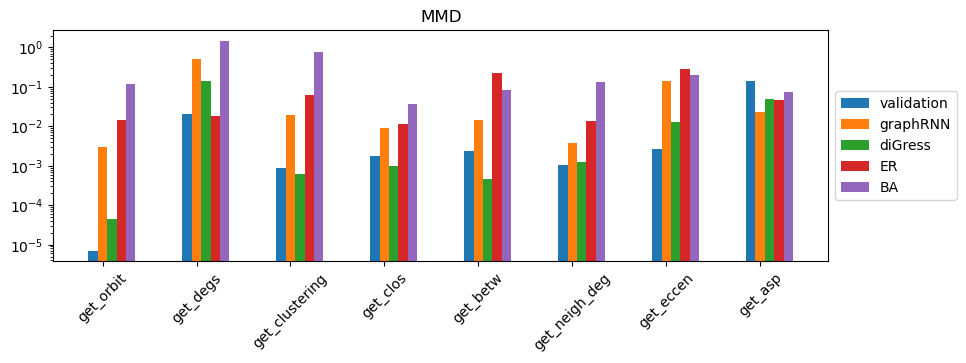

In [148]:
plt.figure(figsize=(10,3))
models = ["validation", "graphRNN","diGress","ER","BA"]
delta = [-0.1,0,+0.1,+0.2,0.3]
c = 0
for i in range(len(values[0])):
    val = values[:,i]
    x = np.array(range(len(values)))
    plt.bar(x+delta[c],val,width=0.1,label=models[c])
    c = c + 1

plt.xticks(range(len(names)),names,rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("MMD")
plt.yscale("log")

In [149]:
def within_out_com_density(graphs):
    within_com = []
    out_com = []
    c = 0 
    for g_in_ori in graphs:
        g_in = g_in_ori.copy()
        for com in list(nx.community.greedy_modularity_communities(g_in)):
            g = nx.subgraph(g_in,com)
            d = nx.density(g)
            within_com.append(d)        
            g_in.remove_edges_from(g.edges)
        c = c + 1
        out_com.append(nx.density(g_in))
     
    return [np.mean(within_com),np.std(within_com),np.mean(out_com),np.std(out_com)]

In [151]:
val,orig = load_orig("sbm")
path = "../../Generate_graphs/generated/graphrnn/sbm/GraphRNN_RNN_sbm_4_128_pred_2900_1.dat"
graphRNN = load_graphRNN(path)[0:len(orig)]
path = "../../Generate_graphs/generated/digress/sbm_0_fullprec_resume/generated_adjs.npz"
digress = load_digress(path)

(0.0, 0.03)

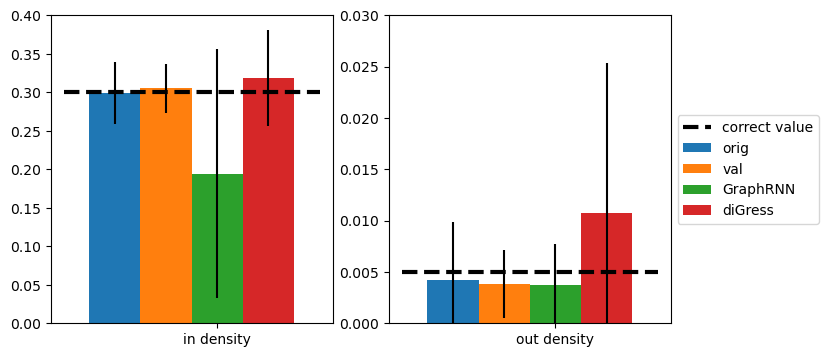

In [153]:
fig, axs = plt.subplots(1, 2,figsize=(8, 4))


in_m, in_s, ou_m, ou_s = within_out_com_density(orig)
x = np.array(range(1))
axs[0].bar(x-0.2,[in_m],yerr=[in_s],width=0.1,label="orig")
axs[1].bar(x-0.2,[ou_m],yerr=[ou_s],width=0.1,label="orig")

in_m, in_s, ou_m, ou_s = within_out_com_density(val)
x = np.array(range(1))
axs[0].bar(x-0.1,[in_m],yerr=[in_s],width=0.1,label="val")
axs[1].bar(x-0.1,[ou_m],yerr=[ou_s],width=0.1,label="val")


in_m, in_s, ou_m, ou_s = within_out_com_density(graphRNN)
axs[0].bar(x-0,[in_m],yerr=[in_s],width=0.1,label="GraphRNN")
axs[1].bar(x-0,[ou_m],yerr=[ou_s],width=0.1,label="GraphRNN")

in_m, in_s, ou_m, ou_s = within_out_com_density(digress)
axs[0].bar(x+0.1,[in_m],yerr=[in_s],width=0.1,label="diGress")
axs[1].bar(x+0.1,[ou_m],yerr=[ou_s],width=0.1,label="diGress")

axs[0].set_xticks([0],["in density"])
axs[1].set_xticks([0],["out density"])

axs[0].hlines(0.3,-0.3,0.2,linewidth=3,color="black",linestyle="dashed")
axs[1].hlines(0.005,-0.3,0.2,linewidth=3,color="black",linestyle="dashed",label="correct value")
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_ylim(0,0.03)

In [154]:
def modularity_len_comm(graphs):
    mod = []
    len_com = []
    for g in graphs:
        com = list(nx.community.greedy_modularity_communities(g))
        mod.append(nx.community.modularity(g, com))
        len_com.append(len(com))
    return mod,len_com

In [155]:
mod_ori, len_com_ori = modularity_len_comm(orig)
mod_val, len_com_val = modularity_len_comm(val)
mod_rnn, len_com_rnn = modularity_len_comm(graphRNN)
mod_dig, len_com_dig = modularity_len_comm(digress)

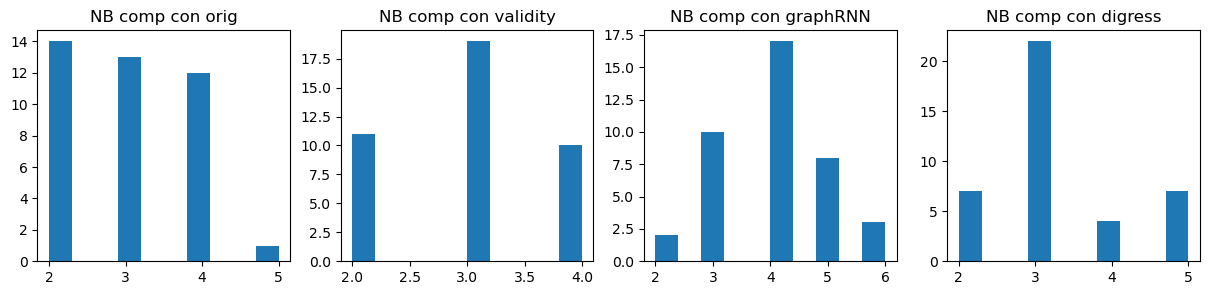

In [157]:
plt.figure(figsize=(15,3))
plt.subplot(141)
plt.title("NB comp con orig")
plt.hist(len_com_ori)
plt.subplot(142)
plt.title("NB comp con validity")
plt.hist(len_com_val)
plt.subplot(143)
plt.title("NB comp con graphRNN")
plt.hist(len_com_rnn)
plt.subplot(144)
plt.title("NB comp con digress")
plt.hist(len_com_dig)
plt.show()

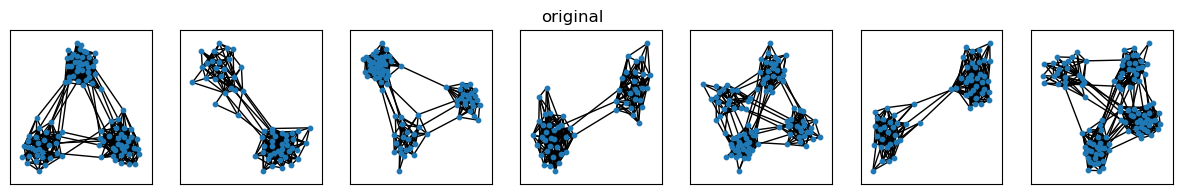

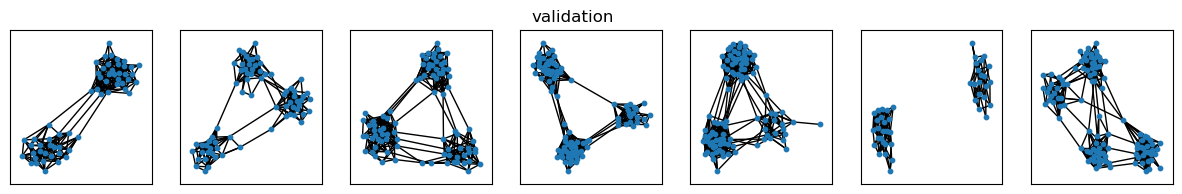

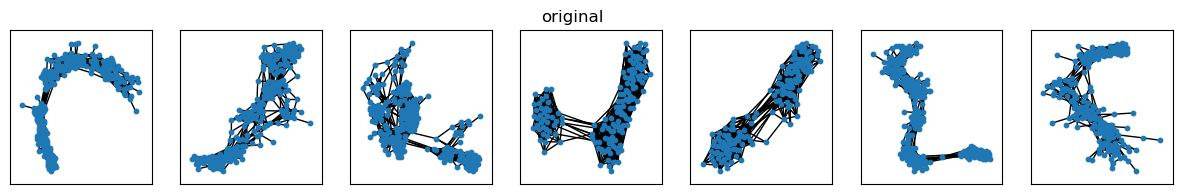

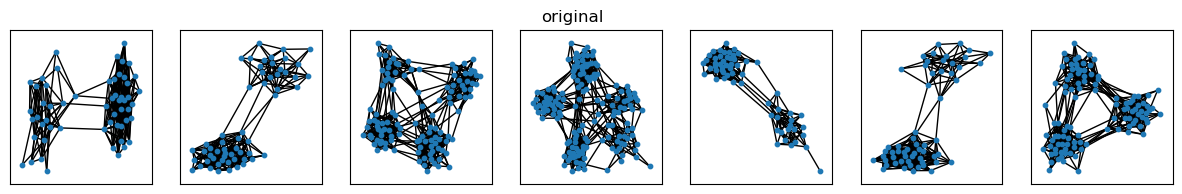

In [160]:
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(orig[i],with_labels=False,node_size=10)

plt.figure(figsize=(15,2))
plt.suptitle("validation")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(val[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(graphRNN[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(digress[i],with_labels=False,node_size=10)

# Planar evaluation

In [178]:
def evluete_planar(orig,competiros,functions=[get_orbit]):
    res = dict()
    for fun in functions:
        fun_name = fun.__name__
        res[fun_name] = []
        s1 = fun(orig)
        sn = []
        for comp in competiros:
            sn = fun(comp)
            if fun_name == "get_degs":
                res[fun_name].append(compute_mmd(s1,sn,kernel=gaussian_emd,is_parallel=False,sigma=1))
            else:
                res[fun_name].append(compute_mmd(s1,sn,kernel=gaussian,is_parallel=False,sigma=1))
        print("done",fun_name)
    return res

In [179]:
val,orig = load_orig("planar")
path = "../../Generate_graphs/generated/graphrnn/planar/GraphRNN_RNN_planar_4_128_pred_3000_1.dat"
graphRNN = load_graphRNN(path)[0:40]
path = "../../Generate_graphs/generated/digress/planar_0_fullprec_resume/generated_adjs.npz"
digress = load_digress(path)

In [180]:
ba = []
er = []
for i in orig:
    ba.append(nx.barabasi_albert_graph(len(i),1))
    er.append(nx.fast_gnp_random_graph(len(i),nx.density(i)))

In [181]:
functions = [get_orbit,get_degs,get_clustering,get_clos,get_betw,get_neigh_deg,get_eccen,get_asp]
res = evluete_planar(orig,[val,graphRNN,digress,er,ba],functions)

done get_orbit
done get_degs
done get_clustering
done get_clos
done get_betw
done get_neigh_deg
done get_eccen
done get_asp


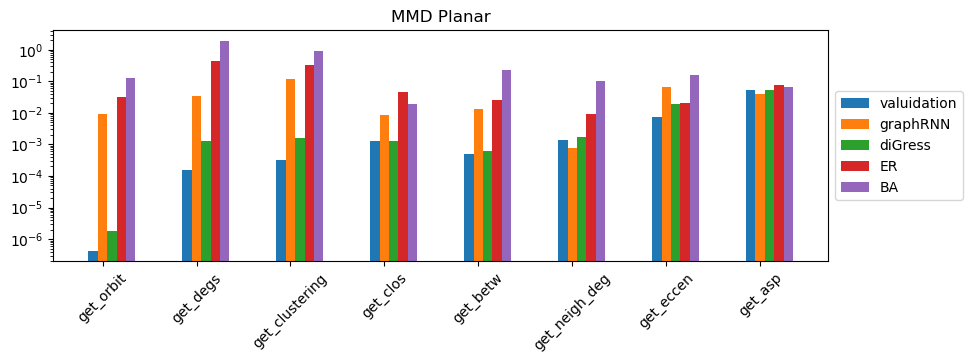

In [186]:
names = []
values = []
for k,v in res.items():
    names.append(k)
    values.append(v)
values = np.array(values)

plt.figure(figsize=(10,3))
models = ["valuidation", "graphRNN","diGress","ER","BA"]
delta = [-0.1,0,+0.1,+0.2,0.3]
c = 0
for i in range(len(values[0])):
    valu = values[:,i]
    x = np.array(range(len(values)))
    plt.bar(x+delta[c],valu,width=0.1,label=models[c])
    c = c + 1

plt.xticks(range(len(names)),names,rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("MMD Planar")
plt.yscale("log")

In [187]:
def is_planar(graphs):
    res = []
    for i in graphs:
        res.append(nx.is_planar(i))
        
    return sum(res)/len(res)

In [190]:
print("perc planar graphs")
print("orig",is_planar(orig))
print("orig",is_planar(val))
print("rnn ",is_planar(graphRNN))
print("digr",is_planar(digress))

perc planar graphs
orig 1.0
orig 1.0
rnn  0.0
digr 0.75


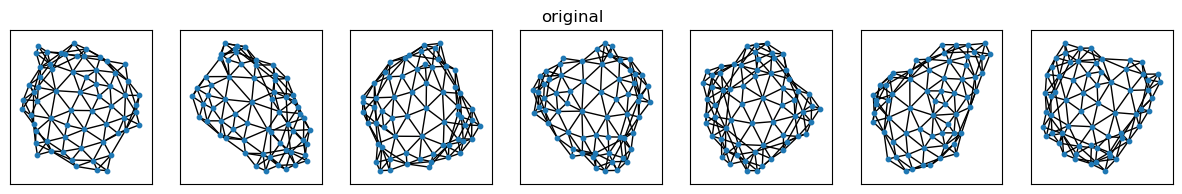

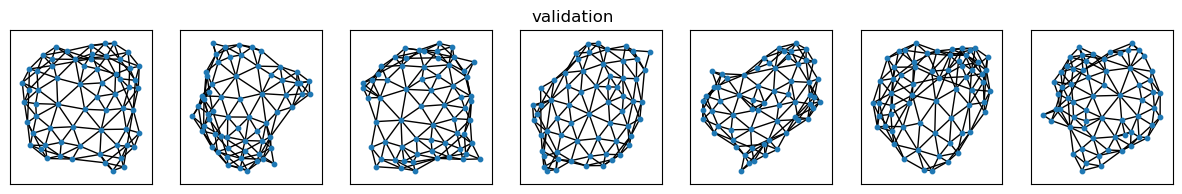

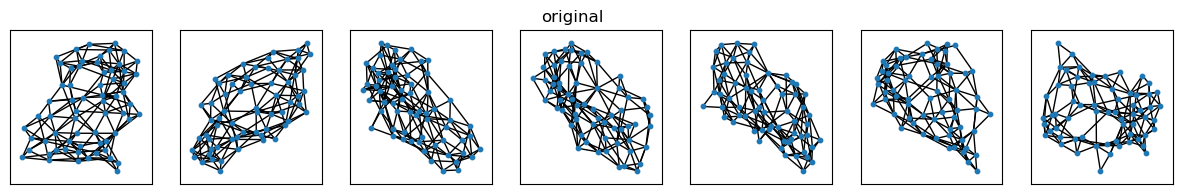

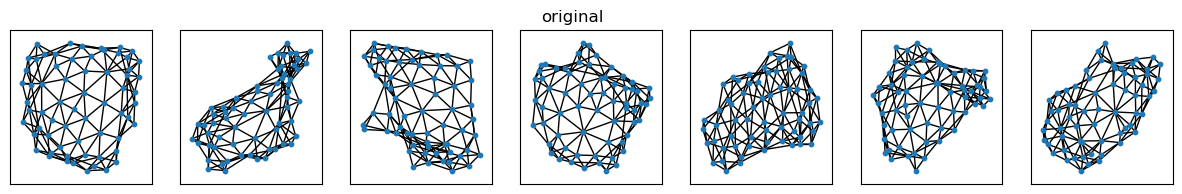

In [191]:
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(orig[i],with_labels=False,node_size=10)

plt.figure(figsize=(15,2))
plt.suptitle("validation")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(val[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(graphRNN[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(digress[i],with_labels=False,node_size=10)

# implement a funtion to measure how much a graph is planar

# ego

In [194]:
val,orig = load_orig("ego")

path = "../../Generate_graphs/generated/graphrnn/ego/GraphRNN_RNN_ego_4_128_pred_1600_1.dat"
graphRNN = load_graphRNN(path)[0:40]
path = "../../Generate_graphs/generated/digress/ego_0_resume/generated_adjs.npz"
digress = load_digress(path)

ba = []
er = []
for i in orig:
    ba.append(nx.barabasi_albert_graph(len(i),1))
    er.append(nx.fast_gnp_random_graph(len(i),nx.density(i)))
    

In [195]:
functions = [get_orbit,get_degs,get_clustering,get_clos,get_betw,get_neigh_deg,get_eccen,get_asp]
res = evluete_planar(orig,[val,graphRNN,digress,er,ba],functions)

done get_orbit
done get_degs
done get_clustering
done get_clos
done get_betw
done get_neigh_deg
done get_eccen
done get_asp


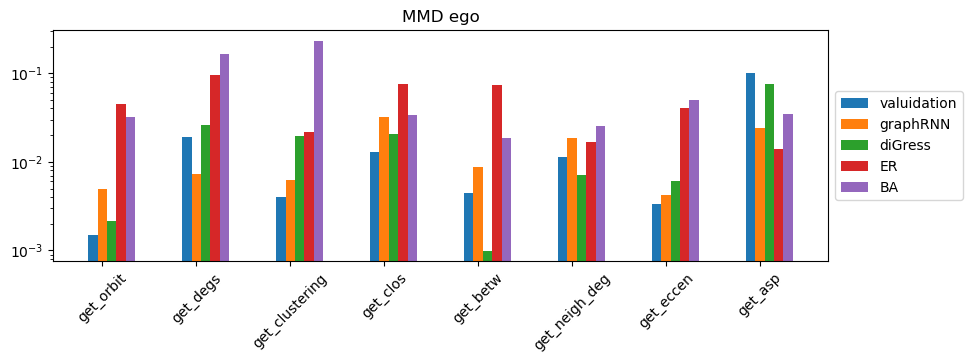

In [196]:
names = []
values = []
for k,v in res.items():
    names.append(k)
    values.append(v)
values = np.array(values)

plt.figure(figsize=(10,3))
models = ["valuidation", "graphRNN","diGress","ER","BA"]
delta = [-0.1,0,+0.1,+0.2,0.3]
c = 0
for i in range(len(values[0])):
    valu = values[:,i]
    x = np.array(range(len(values)))
    plt.bar(x+delta[c],valu,width=0.1,label=models[c])
    c = c + 1

plt.xticks(range(len(names)),names,rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("MMD ego")
plt.yscale("log")

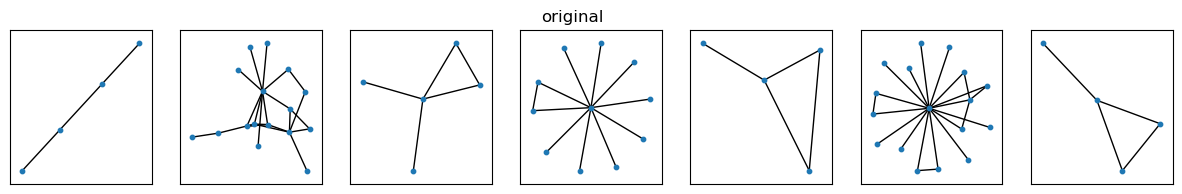

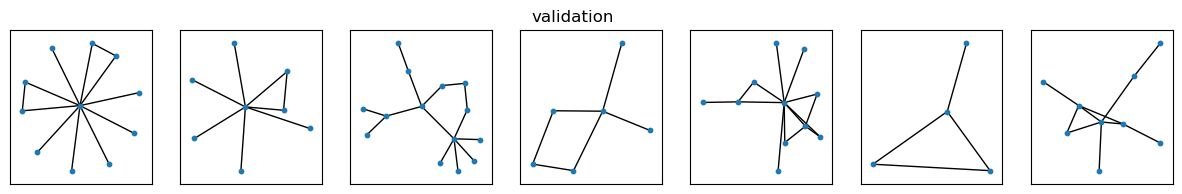

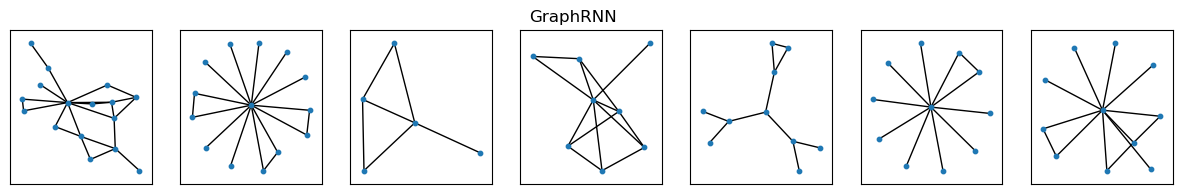

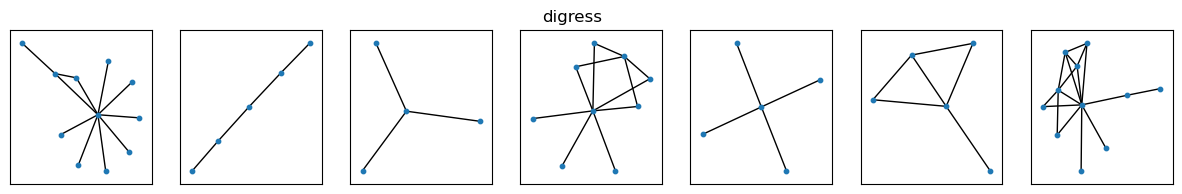

In [198]:
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(orig[i],with_labels=False,node_size=10)

plt.figure(figsize=(15,2))
plt.suptitle("validation")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(val[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("GraphRNN")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(graphRNN[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("digress")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(digress[i],with_labels=False,node_size=10)

# grid 

In [203]:
val,orig = load_orig("grid")
path = "../../Generate_graphs/generated/graphrnn/grid/GraphRNN_RNN_grid_4_128_pred_3000_1.dat"
graphRNN = load_graphRNN(path)[0:40]
path = "../../Generate_graphs/generated/digress/sbm_0_fullprec_resume/generated_adjs.npz"
digress = load_digress(path)[0:40]

In [204]:
ba = []
er = []
for i in orig:
    ba.append(nx.barabasi_albert_graph(len(i),1))
    er.append(nx.fast_gnp_random_graph(len(i),nx.density(i)))

In [205]:
functions = [get_orbit,get_degs,get_clustering,get_clos,get_betw,get_neigh_deg,get_eccen,get_asp]
res = evluete_planar(orig,[val,graphRNN,digress,er,ba],functions)

done get_orbit
done get_degs
done get_clustering
done get_clos
done get_betw
done get_neigh_deg
done get_eccen
done get_asp


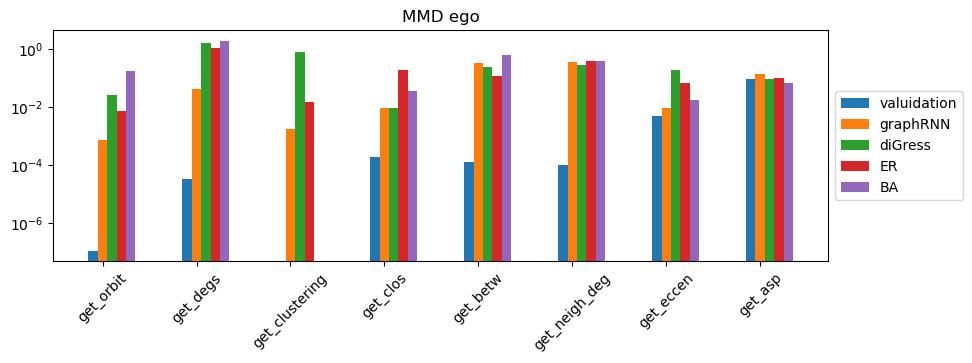

In [206]:
names = []
values = []
for k,v in res.items():
    names.append(k)
    values.append(v)
values = np.array(values)

plt.figure(figsize=(10,3))
models = ["valuidation", "graphRNN","diGress","ER","BA"]
delta = [-0.1,0,+0.1,+0.2,0.3]
c = 0
for i in range(len(values[0])):
    valu = values[:,i]
    x = np.array(range(len(values)))
    plt.bar(x+delta[c],valu,width=0.1,label=models[c])
    c = c + 1

plt.xticks(range(len(names)),names,rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("MMD ego")
plt.yscale("log")

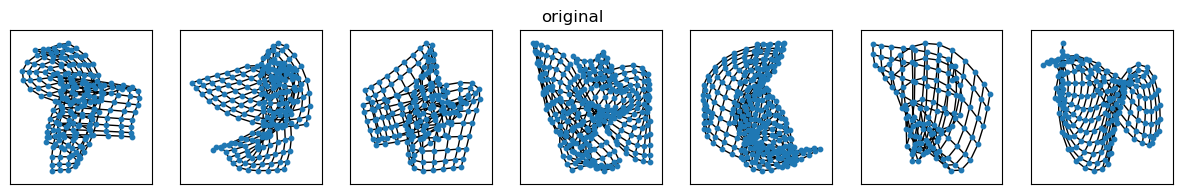

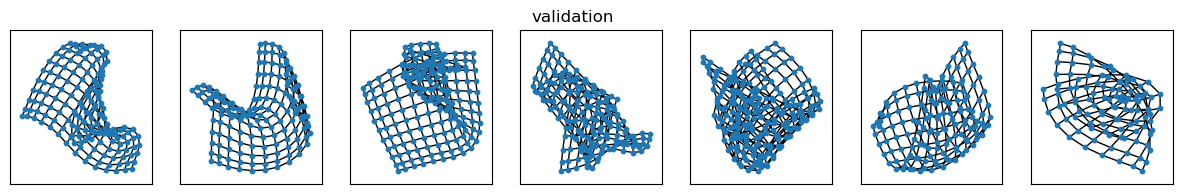

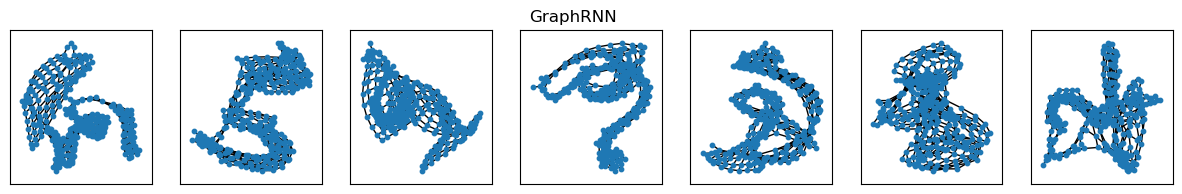

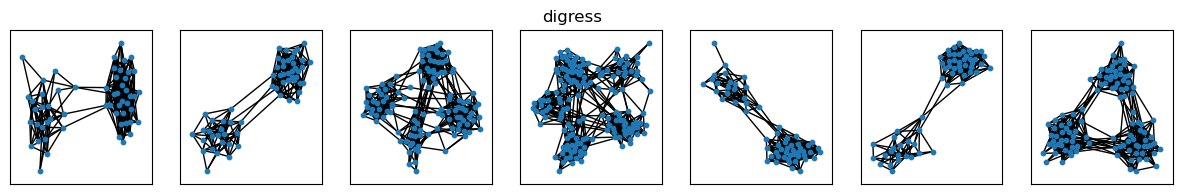

In [207]:
plt.figure(figsize=(15,2))
plt.suptitle("original")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(orig[i],with_labels=False,node_size=10)

plt.figure(figsize=(15,2))
plt.suptitle("validation")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(val[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("GraphRNN")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(graphRNN[i],with_labels=False,node_size=10)    
    
plt.figure(figsize=(15,2))
plt.suptitle("digress")
for i in range(7):
    plt.subplot(1,7,i+1)
    nx.draw_networkx(digress[i],with_labels=False,node_size=10)

In [547]:
def get_valid_ego_grid(grid,radius = 1):
    tmp = []
    for n in grid.nodes():
        ego_g2 = nx.ego_graph(grid,n,radius)

        flag = True
        for g in tmp:
            if nx.could_be_isomorphic(g,ego_g2):
                flag = False
        if flag:
            tmp.append(ego_g2.copy())
    return tmp

In [548]:
grid = nx.grid_graph((40,40))
mapping = dict()
c = 0
for i in grid.nodes():
    mapping[i]=c
    c = c + 1

grid = nx.relabel_nodes(grid, mapping, copy=True)

In [549]:
valid_sub_grid = dict()

for i in range(1,6):
    valid_sub_grid[i] = get_valid_ego_grid(grid,i)

In [550]:
valid_sub_grid

{1: [<networkx.classes.graph.Graph at 0x7f32d8fb4450>,
 2: [<networkx.classes.graph.Graph at 0x7f32dbaf7010>,
 3: [<networkx.classes.graph.Graph at 0x7f32dbbcc250>,
 4: [<networkx.classes.graph.Graph at 0x7f32e098cb90>,
 5: [<networkx.classes.graph.Graph at 0x7f32e09bf050>,
  <networkx.classes.graph.Graph at 0x7f32e0c2bc90>]}

In [556]:

for i in [100,200,500,1000,2000,2500,2600,2700,2800,2900,3000]:
    path = "../../Generate_graphs/generated/graphrnn/grid/GraphRNN_RNN_grid_4_128_pred_"+str(i)+"_1.dat"
    graphRNN = load_graphRNN(path)[0:40]
    res = []
    for g in graphRNN:
        res.append(copute_grid_validity(g,valid_sub_grid))
        
    print("epoch",i,np.mean(res))

epoch 100 1.6698207289865188
epoch 200 1.7516054110997181
epoch 500 1.8211963009442769
epoch 1000 1.928221530976807
epoch 2000 2.169733972544038
epoch 2500 2.312976403491767
epoch 2600 2.366278255612862
epoch 2700 2.460801827676684
epoch 2800 2.495130385422459
epoch 2900 2.595729433960981
epoch 3000 2.509183216595331


In [557]:
for i in [1300]:
    path = "../../Generate_graphs/generated/graphrnn/grid/GraphRNN_RNN_grid_4_128_pred_"+str(i)+"_1.dat"
    graphRNN = load_graphRNN(path)[0:40]
    res = []
    for g in graphRNN:
        res.append(copute_grid_validity(g,valid_sub_grid))
        
    print("epoch",i,np.mean(res))

epoch 1300 1.9917993679313142


In [544]:
orig = load_orig("grid")[0]

In [545]:
res = []
c = 0 
for g in orig:
    res.append(copute_grid_validity(g,valid_sub_grid))
    print(c)
    c = c + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [546]:
np.mean(res),np.std(res)

(6.954993544779642, 0.06365004501419486)

In [486]:
res = []

for radius in [1,2,3,4,5]:
    count = []
    for n in g.nodes():
        ego = nx.ego_graph(g,n,radius)

        flag = False
        for valid in valid_sub_grid[radius]:
            if nx.could_be_isomorphic(valid,ego):
                flag = True

        if not flag:
            count.append(n)
    res.append(count)

In [487]:
for i in res:
    print(len(i))
len(g.nodes())

65
283
324
345
354


362

In [535]:
def copute_grid_validity(g,valid_sub_grid):
    res = []
    nodes = list(g.nodes())

    for radius in valid_sub_grid.keys():
        count = []
        for n in nodes:
            ego = nx.ego_graph(g,n,radius)

            flag = False
            for valid in valid_sub_grid[radius]:
                if nx.could_be_isomorphic(valid,ego):
                    flag = True
            if not flag:
                count.append(n)

        for n in count:
            nodes.remove(n)
        res.append(count)


    avg_val = [len(i) for i in res]
    avg_val = [avg_val[i]*(i+1)    for i in range(len(avg_val))]
    avg_val.append((list(valid_sub_grid.keys())[-1]+1)*len(nodes))
    return sum(avg_val)/len(g.nodes)

2.1629834254143647

In [521]:
g = graphRNN[0]

In [534]:
res = []
nodes = list(g.nodes())

for radius in valid_sub_grid.keys():
    count = []
    for n in nodes:
        ego = nx.ego_graph(g,n,radius)

        flag = False
        for valid in valid_sub_grid[radius]:
            if nx.could_be_isomorphic(valid,ego):
                flag = True
        if not flag:
            count.append(n)

    for n in count:
        nodes.remove(n)
    res.append(count)
    

avg_val = [len(i) for i in res]
avg_val = [avg_val[i]*(i+1)    for i in range(len(avg_val))]
avg_val.append((list(valid_sub_grid.keys())[-1]+1)*len(nodes))

sum(avg_val)

804

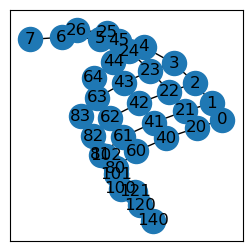

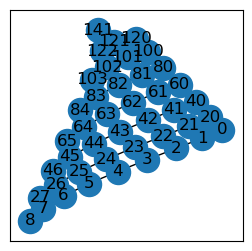

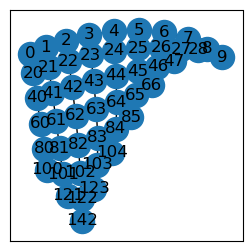

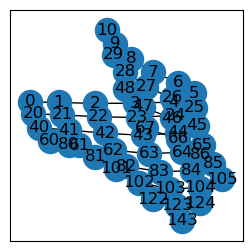

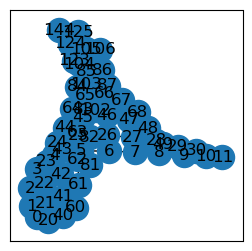

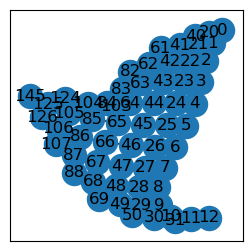

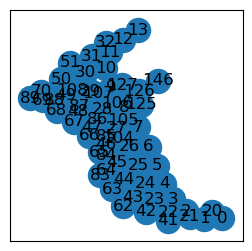

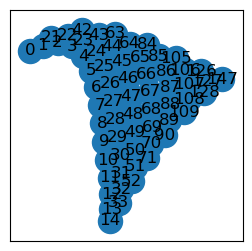

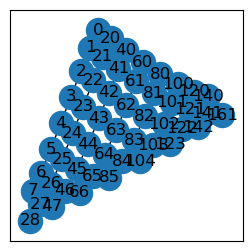

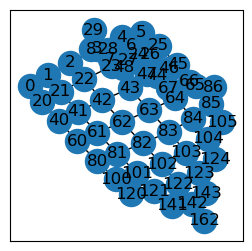

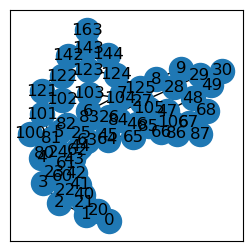

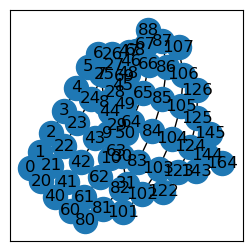

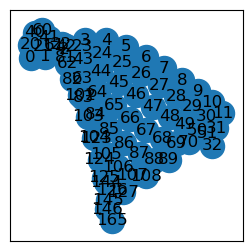

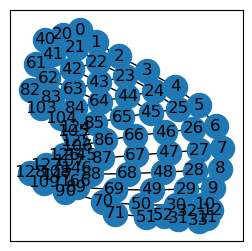

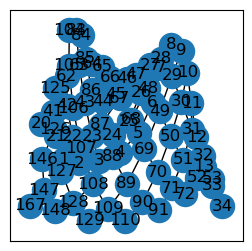

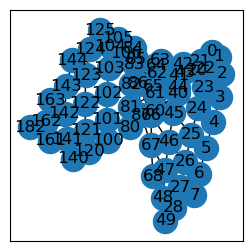

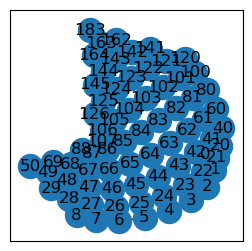

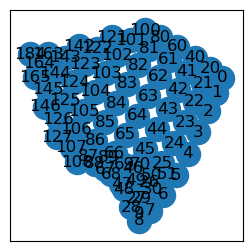

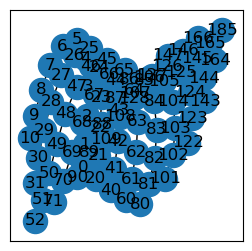

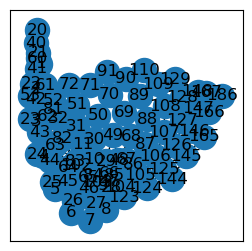

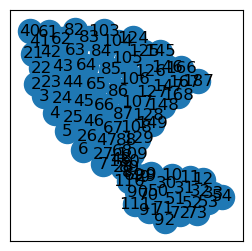

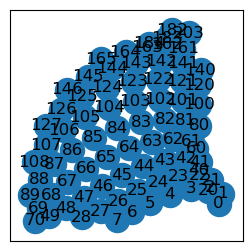

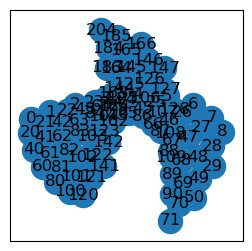

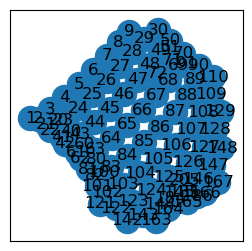

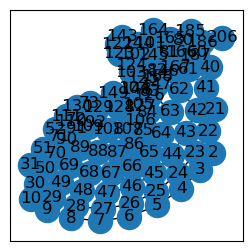

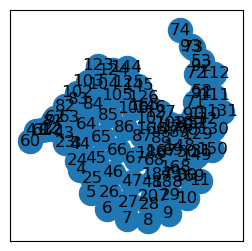

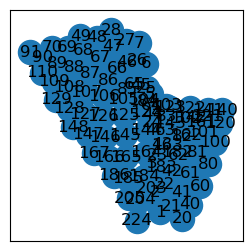

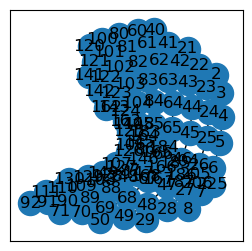

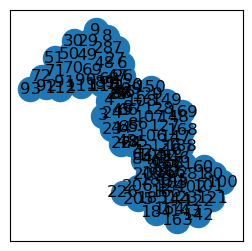

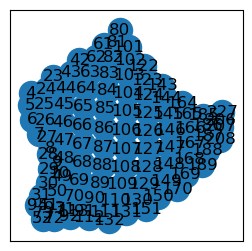

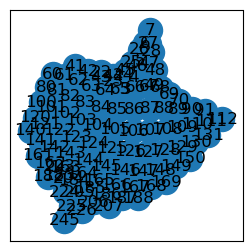

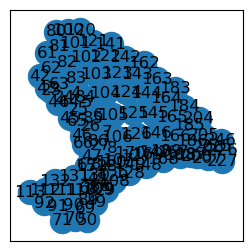

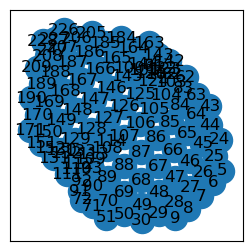

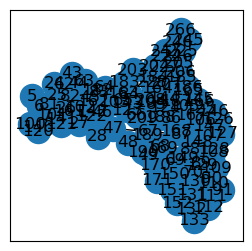

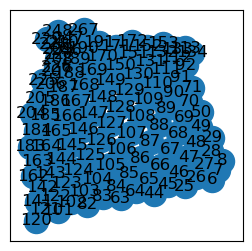

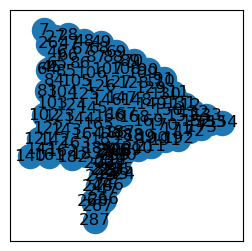

In [398]:
for g in tmp:
    plt.figure(figsize=(3,3))
    nx.draw_networkx(g)           
    plt.show()

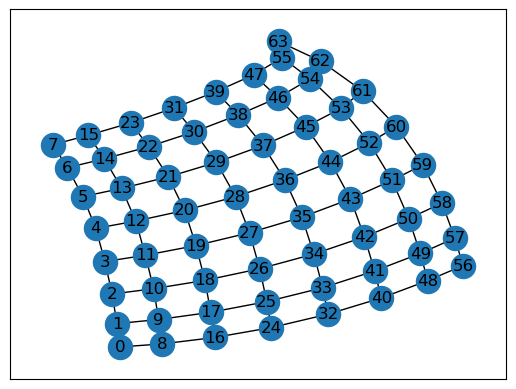

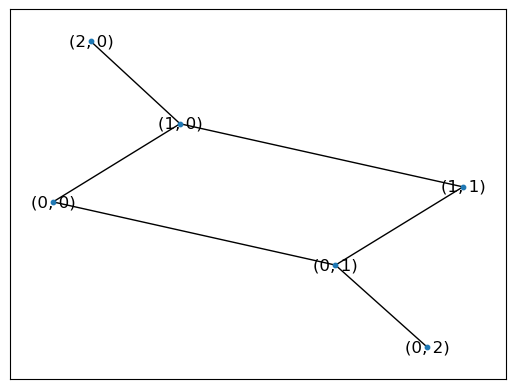

In [245]:
grid = nx.grid_graph((5,5))

nx.draw_networkx(nx.ego_graph(grid,(0,0),2),node_size=10,with_labels=True)

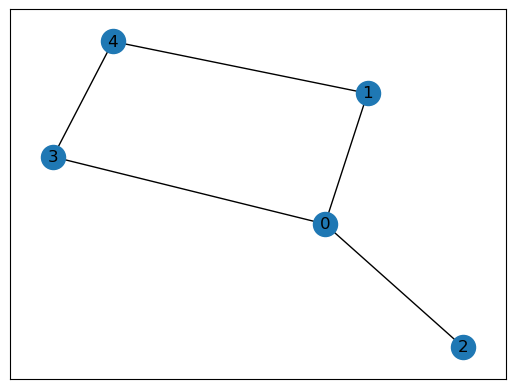

In [243]:
gg = nx.subgraph(g,[0,1,2,3,4])

nx.draw_networkx(gg)

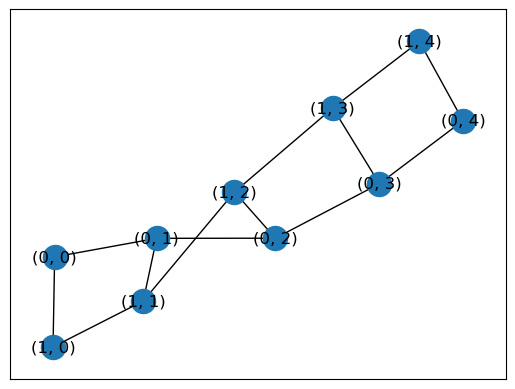

In [223]:
a = nx.grid_graph((5,2))
nx.draw_networkx(a)

# does the graph has triangles?

In [ ]:
generated_graph = []
MAX_nb_nodes = 20
min_nb_nodes = 15

for i in range(20):
    n = np.random.choice(np.arange(min_nb_nodes,MAX_nb_nodes))
    generated_graph.append(nx.barabasi_albert_graph(n,1))
    generated_graph.append(nx.fast_gnp_random_graph(n,0.04))

In [ ]:
def has_tringles(graph):
    count = sum(nx.cluster.triangles(graph).values())
    
    if count == 0:
        return False
    else:
        return True
    
def chack_validity_triangles(graphs):
    N = len(graphs)
    c = 0
    for graph in graphs:
        if has_tringles(graph):
            c = c + 1
            
    print(N,c)
    print(N-c, "valid graphs over",N,"graphs")
    
    return (N,c)

In [ ]:
chack_validity_triangles(generated_graph)